### This is the implementation of a very simple GAN (Generative Adversarial Model).

This is first trial at implementing an algorithm from a research paper; in this case, 'Generative Adversarial Nets' (https://arxiv.org/pdf/1406.2661.pdf).

For this implementation, I am using many resources and basically just dipping my toes in the world of applied ML, as I hope to to gain two main outcomes of this. First, I would like to improve my actual coding skills when it comes to implementing ML/DL algorithms, as I would like to eventually be able to actually read complex publications and implement them myself. This will also help me stay updated with the new advancements happening in this field. Second, it will hopefully keep me in touch with the actual technical part and prevent me from simply being an 'implementer of github projects'. 

PS: the actual code for this implementation is from the following Medium article: https://towardsdatascience.com/converting-deep-learning-research-papers-to-code-f-f38bbd87352f. I just made very small changes and added more detailed comments for more clarity.


In [1]:
# Import required libraries
import torch
from torch import nn

from torch import optim
from torchvision.transforms import transforms

import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Using a single image as the training dataset for the generator.
One of the datasets used by the authors of the paper is MNIST, which I will work on using after I finish writing the basic structure and implementation of the network.

torch.Size([3, 32, 32])


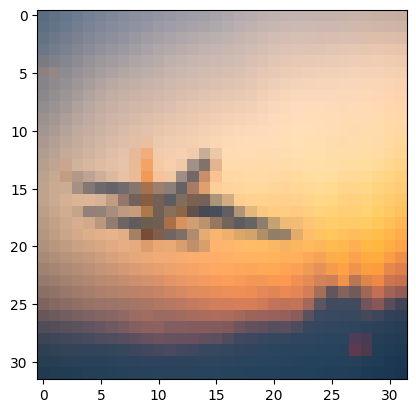

In [3]:
# transforms.Compose allows us to combine multiple changes that we wish to do to an input image;
# in this case, the image is first being resized to 32x32 and then converted to a Pytorch tensor.
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# size of the flattened image
flat_img = 32*32*3

img = Image.open('/home/achalhoub/dev/research_implementations/GAN_pt/input/plane_GAN.jpg')

# resize the real image and convert it to a tensor
real_img = transform(img)

torch.manual_seed(7)

# fake noise for image generation
fake_img = torch.rand(1, 100)

# show the image tensor
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
print(real_img.size())

Creating the Discriminator, which looks at an input image and outputs a '0' of it thinks the image is fake and a '1' if it thinks the image is real.

In [4]:
# defines a custom nn module, used for custom models.
# a sequential model, which is made up of the input layer of
# size 32*32*3 and a ReLU activation function and a single hidden layer
# with 10000 nodes, and finally an output layer of size 10000 with a sigmoid 
# activation function, is instantiated.

# a method for the forward pass is also created, which first flattens the
# input image and then performs a forward pass of the image through the Discriminator.
# this method then returns the output result that is coming from the sigmoid function.

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(flat_img, 10000),
            nn.ReLU(),
            nn.Linear(10000, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        # flattens the input data
        img = img.view(1, -1)
        # performs the forward pass
        out = self.linear(img)

        return out

Creating the Generator, which creates an output image tensor (fake image) using input random noise. The size of the fake image is the same size as that of the real image.

In [5]:
# defines a custom nn module, used for custom models.
# a sequential model, which is made up of the input layer of
# size 100 and a LeakyReLU activation function and two hidden layers
# with 10000 nodes and 4000 noges, and finally an output layer of size
# 32*32*3, is instantiated.

# a method for the forward pass is also created, which first flattens the
# input image and then performs a forward pass of the image through the Generator.
# this method then returns the output 'fake' image produced by the generator.

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(100, 10000),
            nn.LeakyReLU(),
            nn.Linear(10000, 4000),
            nn.LeakyReLU(),
            nn.Linear(4000, flat_img)
        )

    def forward(self, latent_space):
        # flattens the input data
        latent_space = latent_space.view(1, -1)
        # performs the forward pass
        out = self.linear(latent_space)

        return out

Initializing the models, optimizers, and loss function.

In [6]:
# use the GPU if cuda is available. otherwise use the CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# initialize the models and assign them to the device available
discr = Discriminator().to(device)
gen = Generator().to(device)

# initialize the optimizers for both parameters. here we use SGD
opt_d = optim.Adam(discr.parameters(), lr=3e-4)
opt_g = optim.Adam(gen.parameters(), lr=0.3e-4)

# initialize the loss function. the paper uses BCE (Binary Cross Entropy)
criterion = nn.BCELoss()

Train the model. The tutorial I am following trains the whole GAN (discriminator + generator) for 500 epochs. For each epoch of the whole GAN, the discriminator is trained for 4 epochs and the generator will be trained for 3 epochs.

In [7]:
# define epoch values for all training loops
epochs = 30

# define the loop for the overall GAN training (500 epochs).
# 'total' is used to specify the total number of expected
# iterations (https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/)

discr_losses = []
gen_losses = []

for epoch in tqdm(range(epochs), total=epochs):

    #############################
    # Training the discriminator
    #############################

    # set the gradients of all optimized 'torch.Tensor's to zero.
    # (https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)
    opt_d.zero_grad()

    # 'real_img.to(device) performs a Tensor device conversion. in this case,
    # it sets the input image, real_img, on the device we previously defined (GPU).
    # this also performs the forward pass and returns an output value from the
    # sigmoid activation function (a value between 0 and 1).
    out_d1 = discr(real_img.to(device))

    # this measures the Binary Cross Entropy between the target and the
    # input probability. 'out_d1' is the output of the forward pass.
    # 'torch.ones((1, 1)).to(device)' is a 1x1 tensor of value 1, which
    # stands for the value of the real image (remember, fake=0 & real=1).
    # (https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)
    real_loss = criterion(out_d1, torch.ones_like(out_d1).to(device))

    # generate a fake image from the Generator using the input latent space.
    # 'detach' is used to return a tensor that is detached from the current
    # graph, meaning that the tensor will never require gradient.
    gen_output = gen(fake_img.to(device)).detach()

    # same process as described above, however this time using a fake image
    # which is created by the generator.
    out_d2 = discr(gen_output.to(device))
    fake_loss = criterion(out_d2, torch.zeros_like(out_d2).to(device))
    loss_d = (fake_loss + real_loss) / 2    # calculate total Discriminator loss
    discr_losses.append(loss_d.item())
    loss_d.backward()                       # compute gradients (backprop)
    opt_d.step()                            # update parameters


    #############################
    # Training the generator
    #############################

    # set the gradients to zero & generate a fake image
    # with the Generator using the input latent space
    opt_g.zero_grad()
    #out_g = gen(fake_img.to(device))

    discr_pred = discr(gen_output.to(device))
    loss_g = criterion(discr_pred, torch.ones_like(discr_pred))
    gen_losses.append(loss_g.item())
    loss_g.backward()
    opt_g.step()

A Jupyter Widget

gen losses:  [0.9477479457855225, 1.2167797088623047, 1.5364480018615723, 1.9039897918701172, 2.3051986694335938, 2.7279460430145264, 3.160979986190796, 3.595048666000366, 4.022509574890137, 4.4375691413879395, 4.836496829986572, 5.216853618621826, 5.577240943908691, 5.917086601257324, 6.23626184463501, 6.535061836242676, 6.813987731933594, 7.073768138885498, 7.315234184265137, 7.539275646209717, 7.746865749359131, 7.938958644866943, 8.116503715515137, 8.280435562133789, 8.431646347045898, 8.571009635925293, 8.699349403381348, 8.81745433807373, 8.926069259643555, 9.02590560913086]
discr losses:  [0.6453284025192261, 0.24520067870616913, 0.1756180226802826, 0.12112745642662048, 0.08065573871135712, 0.05253525450825691, 0.03379338979721069, 0.021654317155480385, 0.013921688310801983, 0.009035132825374603, 0.005947567522525787, 0.003983228467404842, 0.0027195727452635765, 0.001895080553367734, 0.0013483449583873153, 0.0009795479709282517, 0.0007263330626301467, 0.0005494393408298492, 0.00

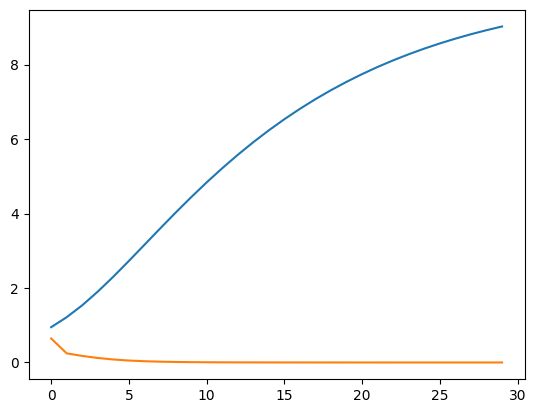

In [8]:
print('gen losses: ', gen_losses)
print('discr losses: ', discr_losses)
plt.plot(gen_losses)
plt.plot(discr_losses)

Plot the original image and the last fake image generated by the Generator to compare the results.

NameError: name 'out_g' is not defined

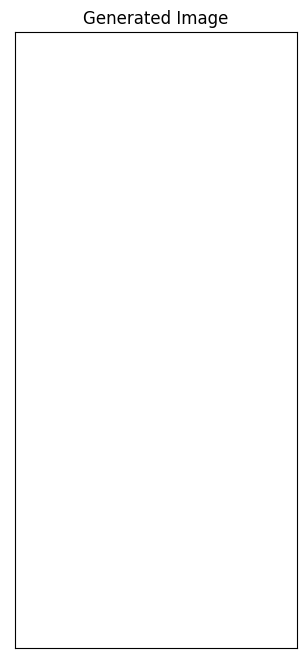

In [9]:
plt.figure(figsize=(8, 8))

# Plot the fake image generated by the Generator
plt.subplot(1, 2, 1)
plt.title("Generated Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(out_g.resize(3, 32, 32).cpu().detach().numpy(), (1, 2, 0)))

# Plot the original real image
plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))

plt.show()